# NLP with Disaster Tweeters

In [153]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer
from tensorflow.keras import preprocessing as kprocessing
from tensorflow.keras import models, layers, optimizers
import gensim.downloader as api

In [154]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/nlp-getting-started/sample_submission.csv
/kaggle/input/nlp-getting-started/train.csv
/kaggle/input/nlp-getting-started/test.csv


## Description

Build a machine learning model that predicts which Tweets are about real disasters and which one’s aren’t. You’ll have access to a dataset of 10,000 tweets that were hand classified.

## EDA

We start the EDA calling the data and briefling checking the what train and test data look like

In [155]:
train_data =pd.read_csv('../input/nlp-getting-started/train.csv')

In [156]:
train_data

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


In [157]:
test_data = pd.read_csv('../input/nlp-getting-started/test.csv')

In [158]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


Checking how the submission file look like

In [159]:
submission_sample = pd.read_csv('../input/nlp-getting-started/sample_submission.csv')

In [160]:
submission_sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [161]:
train_data.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [162]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [163]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3263 entries, 0 to 3262
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        3263 non-null   int64 
 1   keyword   3237 non-null   object
 2   location  2158 non-null   object
 3   text      3263 non-null   object
dtypes: int64(1), object(3)
memory usage: 102.1+ KB


In [164]:
len(test_data)

3263

In [165]:
train_data.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


In [166]:
len(train_data)

7613

In [167]:
len(test_data)/(len(test_data)+len(train_data))

0.3000183891136447

In [168]:
label_count = train_data['target'].value_counts()

In [169]:
label_count

target
0    4342
1    3271
Name: count, dtype: int64

Propotion of the training data

Text(0, 0.5, 'Propotion')

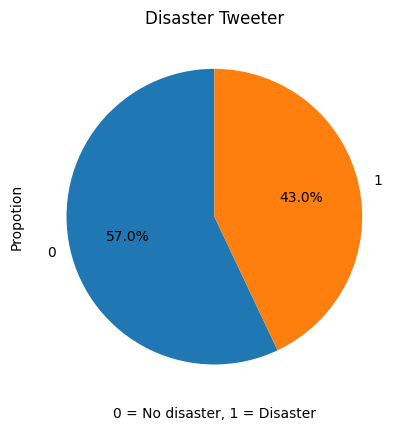

In [170]:
plt.pie(label_count, labels = [0,1], startangle=90, autopct='%1.1f%%')
plt.title('Disaster Tweeter')
plt.xlabel('0 = No disaster, 1 = Disaster')
plt.ylabel('Propotion')

Checking for duplicates tweets

In [171]:
train_data['text'].value_counts()

text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...        10
He came to a land which was engulfed in tribal war and turned it into a land of peace i.e. Madinah. #ProphetMuhammad #islam                      6
The Prophet (peace be upon him) said 'Save yourself from Hellfire even if it is by giving half a date in charity.'                               6
#Bestnaijamade: 16yr old PKK suicide bomber who detonated bomb in ... http://t.co/KSAwlYuX02 bestnaijamade bestnaijamade bestnaijamade beÛ_     6
Madhya Pradesh Train Derailment: Village Youth Saved Many Lives                                                                                  5
                                                                                                                                                ..
Escape The Heat (and the #ORShow) for a trail run on Desolation Loop you'll be glad you did http://t.co/n2ucNzh38

In [172]:
train_data.nunique()

id          7613
keyword      221
location    3341
text        7503
target         2
dtype: int64

We have 7503 texts for 7613 unique ids. That means there are some repeated tweeters on the train data

In [173]:
test_data['text'].value_counts()

text
11-Year-Old Boy Charged With Manslaughter of Toddler: Report: An 11-year-old boy has been charged with manslaughter over the fatal sh...    3
@PumpkinMari_Bot lemme just derail this real quivk to say. HELL DAMN F                                                                      2
Bushfire causes first victim in Albania ::  The multiple fires in Albania have caused the first vict http://t.co/yuba6XmBlq #Bush           2
Wreckage 'Conclusively Confirmed' as From MH370: Malaysia PM                                                                                2
To fight bioterrorism sir.                                                                                                                  2
                                                                                                                                           ..
I liked a @YouTube video from @iglxenix http://t.co/dcxjIJtyYJ Desolation PvP: Beacon Blast Bombardment 3 (Minecraft Xbox One)              1
O

As well as in the test_data

In [174]:
train_data[train_data['text'] == 'Madhya Pradesh Train Derailment: Village Youth Saved Many Lives']

,id,keyword,location,text,target
2439,3503,derailment,Mumbai (India),Madhya Pradesh Train Derailment: Village Youth...,1
2441,3505,derailment,India,Madhya Pradesh Train Derailment: Village Youth...,1
2449,3517,derailment,NaN,Madhya Pradesh Train Derailment: Village Youth...,1
2454,3522,derailment,India,Madhya Pradesh Train Derailment: Village Youth...,1
2477,3552,derailment,NaN,Madhya Pradesh Train Derailment: Village Youth...,1


1. Both train and test data have duplicate tweeters
2. All tweets are in english
3. 43% of the train data are tweeters about disaster
4. 57% of the train data are tweeters with no disasters
5. With a 57/43 proposion train data, the data is not considered imbalanced
6. test data represents 30% of the total data provided

Removing the duplicates

In [175]:
# Duplicate Identification
duplicates = train_data[train_data['text'].duplicated()]
print("Duplicates identified :")
print(duplicates)

Duplicates identified :
         id              keyword        location  \
48       68               ablaze  Live On Webcam   
115     165           aftershock              US   
119     172           aftershock     Switzerland   
164     238  airplane%20accident             NaN   
624     898         bioterrorism             NaN   
...     ...                  ...             ...   
7600  10855                  NaN             NaN   
7607  10867                  NaN             NaN   
7609  10870                  NaN             NaN   
7610  10871                  NaN             NaN   
7611  10872                  NaN             NaN   

                                                   text  target  
48    Check these out: http://t.co/rOI2NSmEJJ http:/...       0  
115   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/vA...       0  
119   320 [IR] ICEMOON [AFTERSHOCK] | http://t.co/TH...       0  
164   Experts in France begin examining airplane deb...       1  
624                  

In [176]:
# Removal of duplicate
train_data_dropped = train_data.drop(duplicates.index)

In [177]:
train_data_dropped.nunique()

id          7503
keyword      221
location    3327
text        7503
target         2
dtype: int64

In [178]:
label_count = train_data_dropped['target'].value_counts()

Text(0, 0.5, 'Propotion')

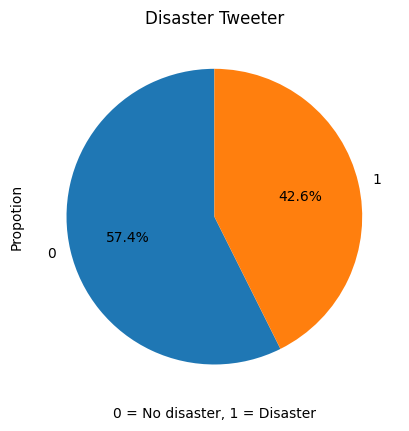

In [179]:
plt.pie(label_count, labels = [0,1], startangle=90, autopct='%1.1f%%')
plt.title('Disaster Tweeter')
plt.xlabel('0 = No disaster, 1 = Disaster')
plt.ylabel('Propotion')

In [180]:
train_data_dropped[train_data_dropped['text'] == 'Madhya Pradesh Train Derailment: Village Youth Saved Many Lives']

,id,keyword,location,text,target
2439,3503,derailment,Mumbai (India),Madhya Pradesh Train Derailment: Village Youth...,1


In [181]:
train_data_dropped['text'][0]

'Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all'

Cleaning the tweets in the training data

In [182]:
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [183]:
sw = stopwords.words('english')
sw.remove('not')

In [184]:
def remove_punct(text):
    text  = "".join([char for char in text if char not in string.punctuation])
    text = re.sub('[0-9]+', '', text)
    return text

In [185]:
def remove_comma_brackets(lst):
    
    return ' '.join(str(x) for x in lst)

In [186]:
def clean_df_column(df, column):
    df[column] = df.apply(lambda row: row[column].lower(),axis=1)
    df[column] = df.apply(lambda row: re.sub("@[A-Za-z0-9_]+","", row[column]),axis=1)
    df[column] = df.apply(lambda row: re.sub("#[A-Za-z0-9_]+","", row[column]),axis=1)
    df[column] = df.apply(lambda row: re.sub(r"http\S+","", row[column]),axis=1)
    df[column] = df.apply(lambda row: re.sub(r"www.\S+","", row[column]),axis=1)
    df[column] = df[column].apply(lambda x: remove_punct(x))
    df[column] = df.apply(lambda row: re.sub("[^a-z0-9]"," ", row[column]),axis=1)
    df[column] = df.apply(lambda row: row[column].split(),axis=1)
    df[column] = [word for word in df[column]if not word in sw]
    df[column] = df[column].apply(lambda x: remove_comma_brackets(x))
    return df[column]
    

In [187]:
train_data_dropped['text'] = clean_df_column(train_data_dropped, 'text')

In [188]:
train_data_dropped

,id,keyword,location,text,target
0,1,NaN,NaN,our deeds are the reason of this may allah for...,1
1,4,NaN,NaN,forest fire near la ronge sask canada,1
2,5,NaN,NaN,all residents asked to shelter in place are be...,1
3,6,NaN,NaN,people receive evacuation orders in california,1
4,7,NaN,NaN,just got sent this photo from ruby as smoke fr...,1
...,...,...,...,...,...
7604,10863,NaN,NaN,fallen powerlines on glink tram update fire cr...,1
7605,10864,NaN,NaN,on the flip side im at walmart and there is a ...,1
7606,10866,NaN,NaN,suicide bomber kills in saudi security site mo...,1
7608,10869,NaN,NaN,two giant cranes holding a bridge collapse int...,1


In [189]:
train_data_dropped['text'][0]

'our deeds are the reason of this may allah forgive us all'

In [190]:
train_data_dropped['text'][100]

'police had previously died in a road accident they were not killed by explosion'

### Split Data

Now, it's time to divide the train data into train and validation data to be able to apply the LSTM architecture and create the models.

As mentioned above the test data is 30% of the total data, so I will keep 50% of the total data as train and 20% of the total data as validation data

So, based on that my split rate will be 28.57% of the traio data which corresponds to 20% of the total data

In [191]:
split_rate = 0.2857

## Embedding Strategy

The embedding strategy I chose was the word2vec to vectorize the tweets in order to send to the model. This is a technique that was published in 2013 and had a considerable impact in NLP. It consists of describing a word with a vector of a given size (typically 100 or 300). The vector for a given word is defined by its context within texts (i.e. based on words on its left and its right — N words on the left, N words on the right, N being typically 5). Typically, word embeddings is trained on huge text corpuses. Word2Vec was trained on millions of Google News

### Word2Vec

In [192]:
X_tf = train_data_dropped['text']
y_tf_class = train_data_dropped['target']

In [193]:
lab = LabelBinarizer()
lab.fit(y_tf_class)
y_tf = lab.transform(y_tf_class)

In [194]:
X_tf_train, X_tf_test, y_tf_train, y_tf_test = train_test_split(X_tf, y_tf, test_size=split_rate, random_state=42, stratify=y_tf_class)

## LSTM Model

After embedding the data, we will tokenize it before putting in the LSTM model

In [195]:
corpus = X_tf_train
max_words = 11142
tokenizer = kprocessing.text.Tokenizer(lower=True, split=' ', num_words=max_words, oov_token="<pad>", filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(corpus)
voc = tokenizer.word_index
reverse_voc = dict([(value, key) for (key, value) in voc.items()])

In [196]:
max_len = 200

sequences = tokenizer.texts_to_sequences(X_tf_train)
X_tf_train_seq = kprocessing.sequence.pad_sequences(sequences, maxlen=max_len)

# Apply the same to test data
X_tf_test_seq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(X_tf_test), maxlen=max_len)

n=10 # You can adjust n
print('Shape: ',X_tf_train_seq.shape)
print(100*'-')
print('Example: ',X_tf_train_seq[n,:])
Shape:  (5359, 200)

Shape:  (5359, 200)
----------------------------------------------------------------------------------------------------
Example:  [   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0  

In [197]:
len(X_tf_train_seq)

5359

In [198]:
len(X_tf_test_seq)

2144

In [199]:
# This may take several minutes
w2v = api.load("word2vec-google-news-300")
# Example of a word representation:
w2v['hello'].shape
(300,)
# Build weights of the embbeddings matrix using w2v
emb_matrix=np.zeros((max_words+1, 300))
for i in range(max_words):
    w = reverse_voc[i+1]
    if w in w2v:
        emb_matrix[i+1,:] = w2v[w]
emb_size = emb_matrix.shape[1]

In [200]:
embedding_layer = tf.keras.layers.Embedding(
    max_words+1,
    emb_size,
    input_length=200, 
    weights=[emb_matrix], 
    trainable=False
)

In [201]:
# Model Definition with LSTM
model_lstm = tf.keras.Sequential([
    embedding_layer,
    tf.keras.layers.SpatialDropout1D(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(200,dropout=0.50,return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(100, dropout=0.50,return_sequences=True)),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Conv1D(200, 5, activation='relu'),
    tf.keras.layers.GlobalMaxPool1D(),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(100, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.20),
    tf.keras.layers.Dense(1, activation='sigmoid')
])


# Setting the training parameters
model_lstm.compile(loss='binary_crossentropy',optimizer=tf.keras.optimizers.experimental.Nadam(5e-5),
                   metrics=['accuracy'])

# Printing the model summary
model_lstm.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 200, 300)          3342900   
                                                                 
 spatial_dropout1d (Spatial  (None, 200, 300)          0         
 Dropout1D)                                                      
                                                                 
 bidirectional (Bidirection  (None, 200, 400)          801600    
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 200, 400)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 200, 200)          400800    
 onal)                                                           
                                                        

In [202]:
history = model_lstm.fit(X_tf_train_seq, y_tf_train, batch_size=64, shuffle=True, epochs=10, validation_data=(X_tf_test_seq, y_tf_test))

Epoch 1/10
84/84 [==============================] - 173s 2s/step - loss: 0.6726 - accuracy: 0.5766 - val_loss: 0.6470 - val_accuracy: 0.6483
Epoch 2/10
84/84 [==============================] - 156s 2s/step - loss: 0.6051 - accuracy: 0.6876 - val_loss: 0.5724 - val_accuracy: 0.7687
Epoch 3/10
84/84 [==============================] - 154s 2s/step - loss: 0.5350 - accuracy: 0.7677 - val_loss: 0.5008 - val_accuracy: 0.7854
Epoch 4/10
84/84 [==============================] - 156s 2s/step - loss: 0.4989 - accuracy: 0.7742 - val_loss: 0.4715 - val_accuracy: 0.8050
Epoch 5/10
84/84 [==============================] - 161s 2s/step - loss: 0.4853 - accuracy: 0.7835 - val_loss: 0.4560 - val_accuracy: 0.8106
Epoch 6/10
84/84 [==============================] - 153s 2s/step - loss: 0.4802 - accuracy: 0.7886 - val_loss: 0.4622 - val_accuracy: 0.8022
Epoch 7/10
84/84 [==============================] - 155s 2s/step - loss: 0.4799 - accuracy: 0.7847 - val_loss: 0.4503 - val_accuracy: 0.8130
Epoch 8/10
84

In [203]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

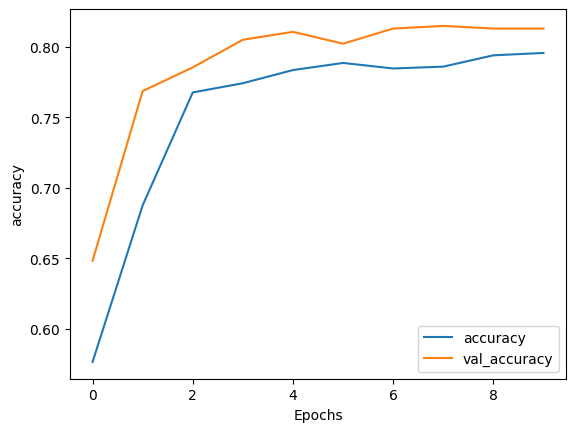

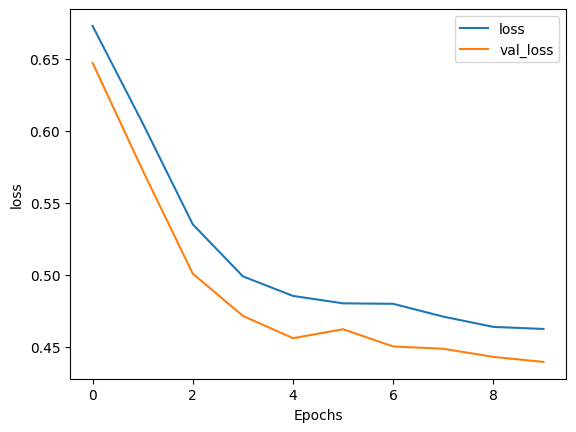

In [204]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

## Test Data

In [205]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan
...,...,...,...,...
3258,10861,NaN,NaN,EARTHQUAKE SAFETY LOS ANGELES ÛÒ SAFETY FASTE...
3259,10865,NaN,NaN,Storm in RI worse than last hurricane. My city...
3260,10868,NaN,NaN,Green Line derailment in Chicago http://t.co/U...
3261,10874,NaN,NaN,MEG issues Hazardous Weather Outlook (HWO) htt...


In [206]:
submission_sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [207]:
test_data['text'] = clean_df_column(test_data, 'text')

In [208]:
test_data

,id,keyword,location,text
0,0,NaN,NaN,just happened a terrible car crash
1,2,NaN,NaN,heard about is different cities stay safe ever...
2,3,NaN,NaN,there is a forest fire at spot pond geese are ...
3,9,NaN,NaN,apocalypse lighting
4,11,NaN,NaN,typhoon soudelor kills in china and taiwan
...,...,...,...,...
3258,10861,NaN,NaN,earthquake safety los angeles safety fasteners...
3259,10865,NaN,NaN,storm in ri worse than last hurricane my citya...
3260,10868,NaN,NaN,green line derailment in chicago
3261,10874,NaN,NaN,meg issues hazardous weather outlook hwo


In [209]:
output = pd.DataFrame(columns = ['id', 'target'])
output['id']=test_data['id']

In [210]:
X_testseq = kprocessing.sequence.pad_sequences(tokenizer.texts_to_sequences(test_data['text']), maxlen=max_len)

In [211]:
len(X_testseq)

3263

In [212]:
output['target'] = tf.math.round(model_lstm.predict(X_testseq)).numpy().astype(int)

102/102 [==============================] - 34s 313ms/step


In [213]:
output

,id,target
0,0,1
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,0


In [214]:
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Result and Conclusion

The model predicted 79% of the tweets

1. The model could have been improved by running a hyperparameter tuning model to fine the model to make better prediction.
2. The learning rate of the model was 0.01, when we check the model accuracy and loss and the comparation between trainingand validation data, we can see that the model is taking too much epochs to achive drop the loss and increase the comparation. 2 thing we could have done: or increase the leaning rate or increase the number of epoches.
3. I could have tried another embedding strategy and compared with Word2vec